In [1]:
import pyupbit
import numpy as np
import pandas as pd
import time
import datetime
import re
import os
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick2_ohlc
import matplotlib.ticker as ticker

pd.set_option('mode.chained_assignment',  None) # 경고 off

# 날짜 갯수 차이 구하기
def cal_data_different(coin, interval, day_count):
    df = pd.read_excel(os.path.join(os.getcwd(),'Data',f"{coin}.xlsx"),index_col=0)
    past = datetime.datetime.strptime(str(df.iloc[-1].name), f'%Y-%m-%d %H:%M:00')
    now = datetime.datetime.now().strftime(f'%Y-%m-%d %H:%M:00')
    now = datetime.datetime.strptime(now, f'%Y-%m-%d %H:%M:00')
    diff = str(now-past)
    n = re.sub(r'[^0-9]', '', interval, day_count)
    h, m, s = list(map(int, diff.split(":")))
    total_time_diff = (h * 60) + m + s # 분으로 환산
    total_diff_num = int(total_time_diff / int(n))

    if "day" in diff: # interval이 day이상 넘어갈 경우
#         print("Create new file")
        df = pyupbit.get_ohlcv(coin, count=day_count, interval=interval)
        time.sleep(0.1)
#         df = df.drop('value', axis=1)
        df = cal_indicators(df)
        df.to_excel(excel_writer=f"./Data/{coin}.xlsx")       # 엑셀 저장
#         print(f"{coin} Data is saved. . . ")
        return df
    else:
        if total_diff_num > 0: # 갱신이 필요할경우
#             print('Update Required.') # str(df.iloc[-1,0])
            orig_df = df.copy()
            dfs = pyupbit.get_ohlcv(coin, count=total_diff_num, interval=interval)
#             dfs = dfs.drop('value', axis=1)
            df = pd.concat([df,dfs], ignore_index=False)
            cal_df = cal_indicators(df[-50:])
            df = pd.concat([orig_df,cal_df[-total_diff_num:]])
            df.to_excel(excel_writer=f"./Data/{coin}.xlsx")
            print(f"Success Update.({coin} update {total_diff_num} amount)")
            return df
        else: # 갱신이 필요 없을 경우
#             print("No update")
            pass
            return df

# 데이터 실시간 저장하기
def save_DataFrame(coin, interval, day_count):
    coin = coin            # 코인명
    interval = interval        # 차트의 종류 (minute1,3,5,10,15,30,60), day
    day_count = day_count           # 데이터 수
    
    if os.path.exists(os.path.join(os.getcwd(),'Data',f"{coin}.xlsx")):# data가 있을 경우
#         print("File exist.")
        pass
        return cal_data_different(coin, interval, day_count)

    else: # data 가 없을 경우
#         print("Create new Dataframe file")
        df = pyupbit.get_ohlcv(coin, count=day_count, interval=interval)
        time.sleep(0.1)
#         df = df.drop('value', axis=1)
        df = cal_indicators(df)
        df.to_excel(excel_writer=f"./Data/{coin}.xlsx")       # 엑셀 저장
#         print(f"{coin} Data is saved. . . ")
        return df

# 현재가 조회
def get_current_price(coin):
    print(pyupbit.get_current_price(coin))
    return pyupbit.get_current_price(coin)

# 보조지표 구하기
def cal_indicators(DataFrame):
    df = DataFrame
    # Moving Average
    df['MA3'] = df['close'].rolling(window=3).mean()
    df['MA5'] = df['close'].rolling(window=5).mean()
    df['MA10'] = df['close'].rolling(window=10).mean()
    df['MA15'] = df['close'].rolling(window=15).mean()
    df['MA20'] = df['close'].rolling(window=20).mean() # 20일 평균 이동 : 중간 볼린저 밴드
    df['MA30'] = df['close'].rolling(window=30).mean()

    # RSI
    rsi_interval = 14
    df['U'] = np.where(df.diff(1)['close'] > 0, df.diff(1)['close'],0)
    df['D'] = np.where(df.diff(1)['close'] < 0, df.diff(1)['close']*(-1), 0)
    df['AU'] = df['U'].ewm(rsi_interval).mean()
    df['AD'] = df['D'].ewm(rsi_interval).mean()
    df['RSI'] = (df['AU'] / (df['AU']+df['AD'])) *100
    # df['RSI_Signal'] = df['RSI'].rolling(9).mean()
    del df['U'], df['D'], df['AU'], df['AD']
    # check signal
    df['RSI buy signal'] = np.where(df['RSI'] < 10, 1, 0)
    df['RSI sell signal'] = np.where(df['RSI'] > 90, -1, 0)
    

    # MACD
    df['MACD_EMA12'] = df['close'].ewm(span=12).mean()
    df['MACD_EMA26'] = df['close'].ewm(span=26).mean()
    df['MACD'] = df['MACD_EMA12'] - df['MACD_EMA26']
    df['MACD_signal'] = df['MACD'].ewm(span=9).mean()
    # check signal
    df['MACD buy signal'] = np.where(df['MACD'] > df['MACD_signal'], 1, 0) # Buy signal
    df['MACD sell signal'] = np.where(df['MACD'] < df['MACD_signal'], -1, 0) # Sell signal

    
    # Bollinger Band
    df['Bollinger_stddev'] = df['close'].rolling(window=20).std() # 20일 이동 표준편차
    df['Bollinger_upper'] = df['MA20'] + (df['Bollinger_stddev'] * 2) # 상단 볼린저 밴드
    df['Bollinger_lower'] = df['MA20'] - (df['Bollinger_stddev'] * 2) # 상단 볼린저 밴드
    # check signal
    df['Bollinger buy signal'] = np.where(df['close'] < df['Bollinger_lower'], 1, 0)
    df['Bollinger sell signal'] = np.where(df['close'] > df['Bollinger_upper'], -1, 0)
    
    
    
    #*------------------------- 추가
    # MDD (최대 낙폭)
    df['last_highest'] = df['close'].cummax()
    df['DD'] = (1-df['close'] / df['last_highest']) * 100
    df['MDD'] = df['DD'].cummax()
    del df['last_highest'], df['DD']
    return df

# 10분당 거래대금 상위 10개 코인 가져오기
def Top_n_Value(n):
    start = time.time()
    # 10분당 거래대금 상위 10개 코인 가져오기
    result = []
    coin_lists = []
    for t in pyupbit.get_tickers(fiat='KRW'): 
        volumes = (t, pyupbit.get_ohlcv(ticker=t, count=1, interval="minute10")['value'].values[0] )
        result.append(volumes)
        time.sleep(0.08)

    result.sort(key=lambda x:x[1], reverse=True)
    for i in result[:n]: # 상위 몇개 가져올건지
        coin_lists.append(i[0])
    print("time :", time.time() - start)
    return coin_lists

def Drawing_Graph(Data_Frame, i, coins):
    df = Data_Frame[-60:]
    start = time.time()
    
    # 그래프 구역 나누기
    top_axes = plt.subplot(len(coins), 1, i+1)
    plt.xticks(rotation=45)
    plt.setp(top_axes.get_xticklabels(), visible=False) # top_axes의 라벨 제거
    #----------------------------------------------------------------------------------#

    # 인덱스 설정
    idx = df.index[:].astype('str')

    # 이동평균선 그리기
    top_axes.plot(idx, df['MA3'], label='MA3', linewidth=0.7)
    top_axes.plot(idx, df['MA5'], label='MA5', linewidth=0.7)
    top_axes.plot(idx, df['MA10'], label='MA10', linewidth=0.7)
    #----------------------------------------------------------------------------------#

    # 캔들차트 그리기
    candlestick2_ohlc(top_axes, df['open'], df['high'], 
                      df['low'], df['close'],
                      width=0.5, colorup='r', colordown='b')
    #----------------------------------------------------------------------------------#

    # 그래프 title 지정
    top_axes.set_title(f'{coins[n]}', fontsize=22)
    # X축 티커 숫자 20개로 제한
    top_axes.xaxis.set_major_locator(ticker.MaxNLocator(10))

    top_axes.legend()
    plt.tight_layout()

time : 14.82290530204773
['KRW-SAND', 'KRW-XRP', 'KRW-SRM', 'KRW-MBL', 'KRW-ADA']
Real-time detection . . .
Success Update.(KRW-XRP update 1 amount)
Success Update.(KRW-MBL update 1 amount)


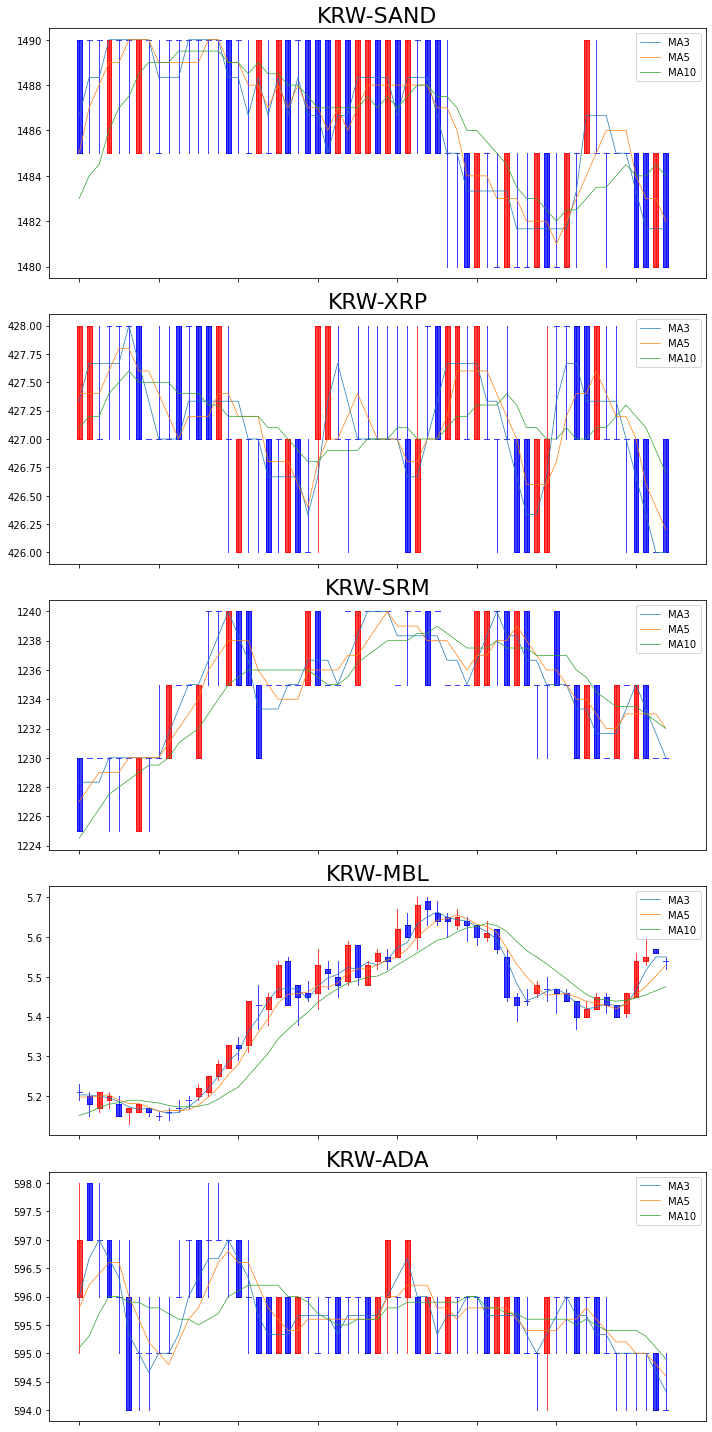

Real-time detection . . .


C:\Users\HAIC\AppData\Local\Temp/ipykernel_14540/3965059943.py:160: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()
C:\Users\HAIC\AppData\Local\Temp/ipykernel_14540/3965059943.py:160: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()
C:\Users\HAIC\AppData\Local\Temp/ipykernel_14540/3965059943.py:160: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()
C:\Users\HAIC\AppData\Local\Temp/ipykernel_14540/3965059943.py:160: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


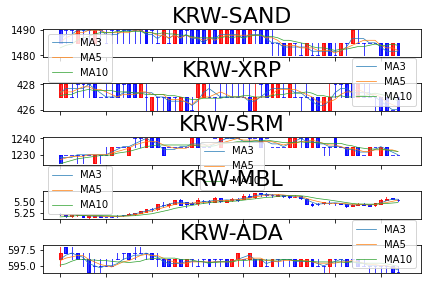

Real-time detection . . .


C:\Users\HAIC\AppData\Local\Temp/ipykernel_14540/3965059943.py:160: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()
C:\Users\HAIC\AppData\Local\Temp/ipykernel_14540/3965059943.py:160: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()
C:\Users\HAIC\AppData\Local\Temp/ipykernel_14540/3965059943.py:160: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


Success Update.(KRW-ADA update 1 amount)


C:\Users\HAIC\AppData\Local\Temp/ipykernel_14540/3965059943.py:160: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


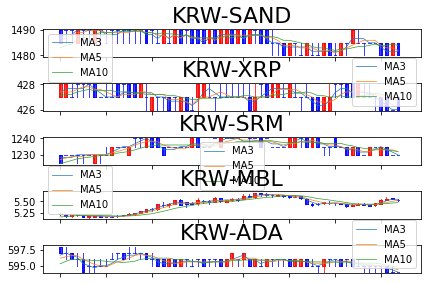

Real-time detection . . .
Success Update.(KRW-SAND update 1 amount)
Success Update.(KRW-XRP update 1 amount)
Success Update.(KRW-SRM update 1 amount)


C:\Users\HAIC\AppData\Local\Temp/ipykernel_14540/3965059943.py:160: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


Success Update.(KRW-MBL update 1 amount)


C:\Users\HAIC\AppData\Local\Temp/ipykernel_14540/3965059943.py:160: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()
C:\Users\HAIC\AppData\Local\Temp/ipykernel_14540/3965059943.py:160: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


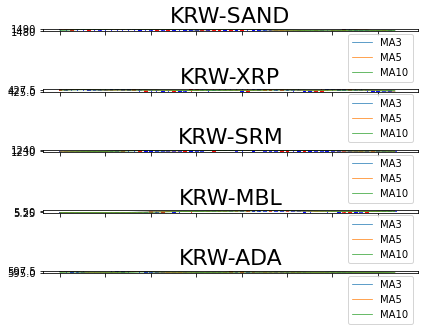

Real-time detection . . .


C:\Users\HAIC\AppData\Local\Temp/ipykernel_14540/3965059943.py:160: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()
C:\Users\HAIC\AppData\Local\Temp/ipykernel_14540/3965059943.py:160: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()
C:\Users\HAIC\AppData\Local\Temp/ipykernel_14540/3965059943.py:160: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()


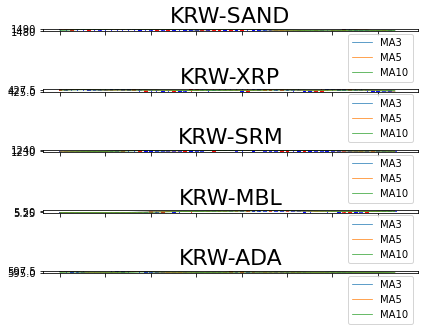

In [3]:
#----------------------------------------------------------------------------------#
# Main

coins = Top_n_Value(5) # 상위 5개 거래 대금의 코인 가져오기
print(coins)

fig = plt.figure(figsize=(10,20)) # 실시간 차트 도화지 설정
fig.clear()
i=0
while i<5 :
    print("Real-time detection . . .")
    for n in range(len(coins)):
        coin = coins[n]
        df = save_DataFrame(coin,'minute1',60*24)
#         Drawing_Graph(df, n, coins)
        time.sleep(1)
#     plt.show(block = False)
#     plt.pause(0.1)
    
    i += 1

In [29]:
#----------------------------------------------------------------------------------#
# Main

coins = Top_n_Value(5) # 상위 5개 거래 대금의 코인 가져오기
print(coins)
print("Real-time detection . . .")


start = time.time()
for n in range(len(coins)):
    coin = coins[n]
    df = save_DataFrame(coin,'minute1',60*24)
    time.sleep(1)
    
print("time :", time.time() - start)

time : 14.865824460983276
['KRW-POWR', 'KRW-MBL', 'KRW-BTC', 'KRW-MANA', 'KRW-XRP']
Real-time detection . . .
time : 12.791149139404297


In [35]:
t = df

In [100]:
df = pd.read_excel('./Data/KRW-BTC.xlsx')

ValueError: x and y must be the same size

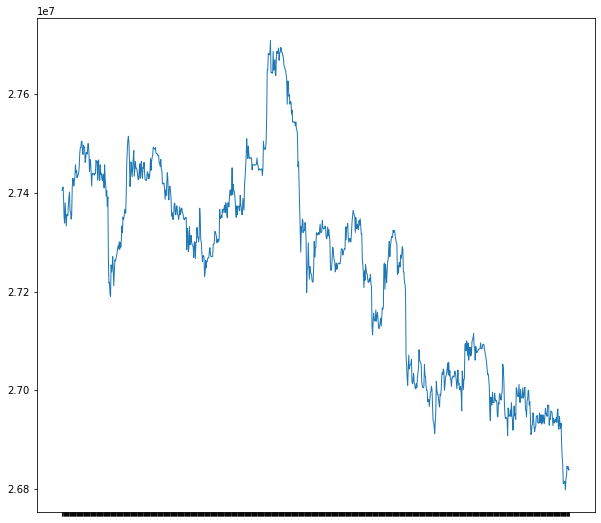

In [101]:
fig = plt.figure(figsize=(10,20)) # 실시간 차트 도화지 설정
df = df[500:]
top = plt.subplot(2,1,1)
plt.setp(top.get_xticklabels(), visible=False) # top_axes의 라벨 제


idx = df.index[:].astype('str')
# 캔들차트 그리기
top.plot(idx, df['close'], linewidth=1)
top.scatter(df.loc[df['MACD buy signal']==1]['close'].index, df['close'], color='green',label = 'Buy',marker="^")
# plt.scatter(idx, df.loc[df['RSI sell signal']==1].index, color='red',label = 'Sell',marker="^")

In [95]:
idx

Index(['1000', '1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008',
       '1009',
       ...
       '1430', '1431', '1432', '1433', '1434', '1435', '1436', '1437', '1438',
       '1439'],
      dtype='object', length=440)

In [63]:
df.loc[df['RSI sell signal']==-1]

,Unnamed: 0,open,high,low,close,volume,MA3,MA5,MA10,MA15,...,MACD,MACD_signal,MACD buy signal,MACD sell signal,Bollinger_stddev,Bollinger_upper,Bollinger_lower,Bollinger buy signal,Bollinger sell signal,MDD


In [96]:
df.loc[df['MACD buy signal']==1]['close'].index

Int64Index([1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022,
            ...
            1401, 1402, 1405, 1406, 1407, 1417, 1418, 1437, 1438, 1439],
           dtype='int64', length=216)